In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import seaborn as sns

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

### A Brief Introduction

#### Project Overview
In this project, we aim to leverage machine learning techniques for the classification of astronomical objects, using data from the Sloan Digital Sky Survey (SDSS). The primary goal is to categorize these objects into three distinct classes: stars, galaxies, or quasars. This classification is vital for astrophysical research and offers insights into the composition and dynamics of the universe.

#### Dataset Description
The dataset is comprised of 100,000 observations from the SDSS, each detailed with 17 feature columns and 1 class column. These features encompass various astronomical and observational data, while the class column labels the object as either a star, galaxy, or quasar.

#### Feature Descriptions and Potential Usefulness

1. **obj_ID (Object Identifier):** 
   - Unique identifier for each object in the image catalog.
   - Important for data tracking and integrity, though not directly used in classification.

2. **Alpha (Right Ascension) and Delta (Declination Angle):** 
   - Specifies the object's sky position.
   - Useful for identifying object clusters in specific sky regions.

3. **Photometric System Filters (u, g, r, i, z):** 
   - Measures light in ultraviolet, green, red, near-infrared, and infrared wavelengths.
   - Crucial for distinguishing object types based on their light emission patterns.

4. **run_ID, rereun_ID, cam_col, field_ID:** 
   - Details about the observation run, image processing, and field identification.
   - Helps identify systematic errors or biases in data collection.

5. **spec_obj_ID (Spectroscopic Object Identifier):** 
   - Unique ID for spectroscopically observed objects.
   - Links photometric and spectroscopic data for comprehensive analysis.

6. **Class (Galaxy, Star, Quasar):**
   - The target variable for classification.
   - Essential for understanding the distribution and characteristics of each class.

7. **Redshift:**
   - Indicates object distance and velocity through wavelength shift.
   - Key for differentiating between nearby stars and distant galaxies or quasars.

8. **Plate and fiber_ID:** 
   - Relates to the observation hardware.
   - Useful for identifying hardware-specific data biases.

9. **MJD (Modified Julian Date):**
   - The observation date.
   - Captures time-related changes in object visibility or properties.

#### Goal
The project's primary objective is to develop an accurate machine learning model for classifying these astronomical objects. Each feature in the dataset provides unique insights into the objects' properties, aiding in the classification process.

#### Loading and checking the Dataset

In [3]:
path_df = "star_classification.csv"
df = pd.read_csv(path_df)

df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

## Data Analysys
I will procede looking for insight and correlation in my data

### Melted Graph for Light Filter Distributions

**Visualization Technique:** The melted graph consolidates brightness readings from multiple photometric filters (u, g, r, i, z) into one visualization, with color-coding for each astronomical class.

**Significance:** This visualization is effective for comparing the emission characteristics of stars, galaxies, and quasars across different light spectra. It is particularly useful for detecting patterns that may influence the classification of these objects based on their photometric properties.

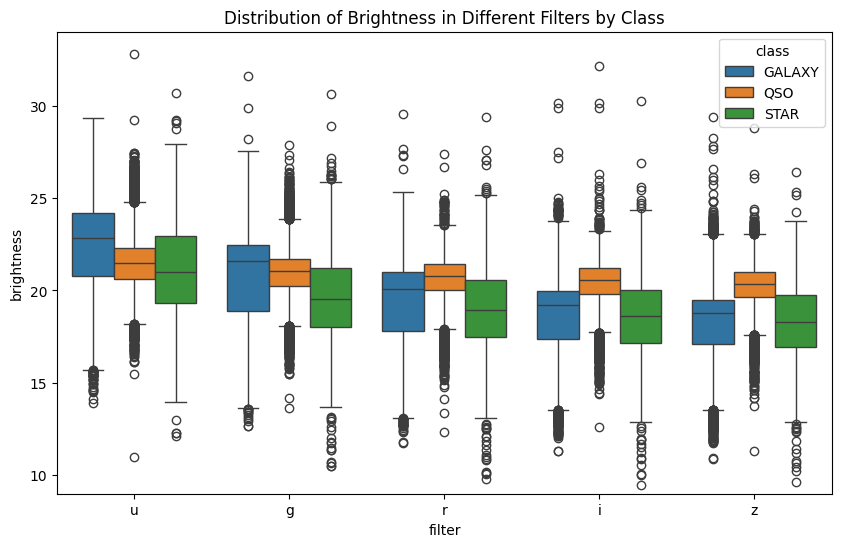

In [6]:
# Melting the DataFrame to have 'filter' and 'brightness' columns
melted_data = df.melt(id_vars='class', value_vars=['u', 'g', 'r', 'i', 'z'], 
                        var_name='filter', value_name='brightness')

plt.figure(figsize=(10, 6))
sns.boxplot(x='filter', y='brightness', hue='class', data=melted_data)
plt.ylim(9, 34)
plt.title('Distribution of Brightness in Different Filters by Class')
plt.show()

### Scatter Plot for Celestial Coordinates

**Visualization Technique:** A scatter plot graphically represents the celestial coordinates of objects, with a color distinction for each class.

**Significance:** The scatter plot provides insights into the distribution of astronomical objects across the sky. It can indicate the existence of clusters or voids in the spatial arrangement of stars, galaxies, and quasars, which is crucial for understanding the large-scale structure of the cosmos.

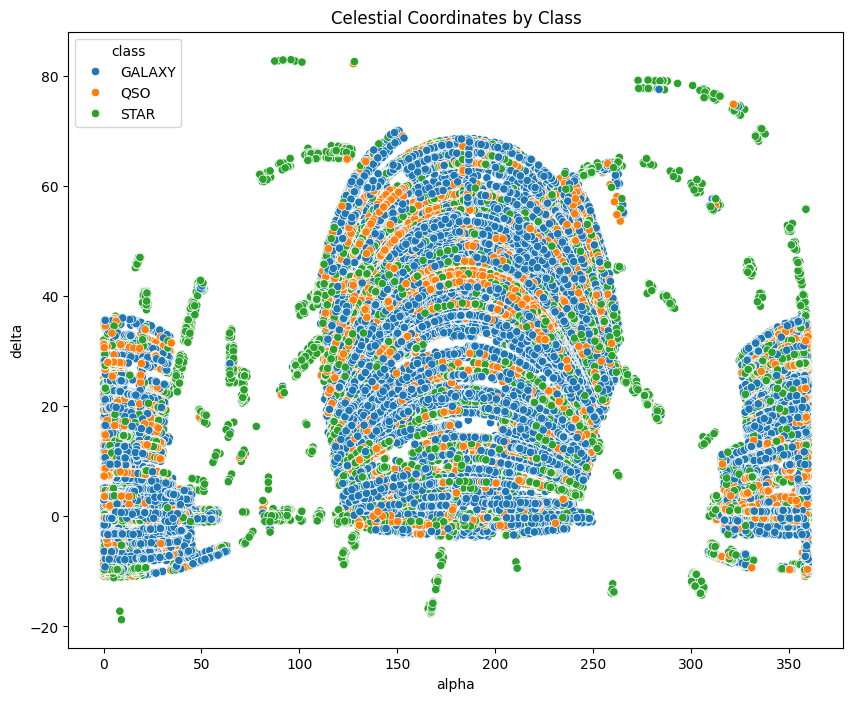

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='alpha', y='delta', hue='class', data=df)
plt.title('Celestial Coordinates by Class')
plt.show()

# Complicated one
# alpha_rad = np.radians(df['alpha'])
# delta_rad = np.radians(df['delta'])
# alpha_rad = alpha_rad - np.pi
# class_mapping = {'GALAXY': 1, 'STAR': 2, 'QSO': 3}
# df['class_numeric'] = df['class'].map(class_mapping)
# plt.figure(figsize=(10, 5))
# ax = plt.subplot(111, projection='mollweide')
# scatter = ax.scatter(alpha_rad, delta_rad, c=df['class_numeric'], cmap='viridis', s=10)
# ax.set_title('Celestial Coordinates (Mollweide Projection)')
# ax.set_xlabel('Right Ascension')
# ax.set_ylabel('Declination')
# ax.grid(True)
# plt.show()

### Histograms for Redshift Distributions by Class

**Visualization Technique:** Separate histograms depict the distribution of redshift values for galaxies, QSOs (quasars), and stars. This approach isolates the data for each class, enabling a focused analysis of redshift frequencies without inter-class overlap.

**Significance:** These histograms are crucial for understanding the distinct astronomical phenomena represented by each class. For galaxies, the histogram may show a wide range of redshift values, highlighting the diversity of galaxy distances and velocities. The QSO histogram likely features higher redshift values, reflecting their typically greater distances and enabling studies into the early universe. The histogram for stars should cluster around lower redshift values, given their proximity within our galaxy, providing insight into local stellar populations.

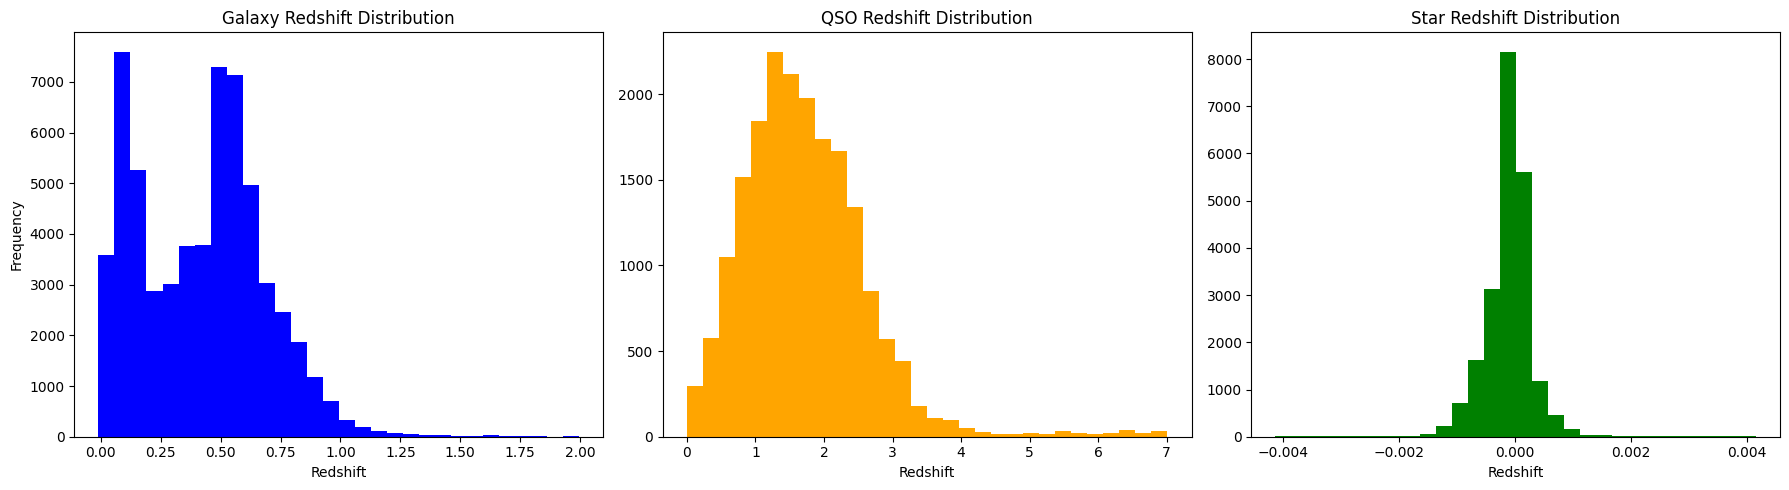

In [8]:

galaxies = df[df['class'] == 'GALAXY']['redshift']
qsos = df[df['class'] == 'QSO']['redshift']
stars = df[df['class'] == 'STAR']['redshift']

plt.figure(figsize=(18, 5))

# Plot for GALAXY
plt.subplot(1, 3, 1)
plt.hist(galaxies, bins=30, color='blue')
plt.title('Galaxy Redshift Distribution')
plt.xlabel('Redshift')
plt.ylabel('Frequency')

# Plot for QSO
plt.subplot(1, 3, 2)
plt.hist(qsos, bins=30, color='orange')
plt.title('QSO Redshift Distribution')
plt.xlabel('Redshift')

# Plot for STAR
plt.subplot(1, 3, 3)
plt.hist(stars, bins=30, color='green')
plt.title('Star Redshift Distribution')
plt.xlabel('Redshift')

# Adjust the layout
plt.tight_layout()
plt.show()


## Feature engineering
The columns 'obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', and 'fiber_ID' were dropped primarily because they contain a large number of unique identifiers, which, if one-hot encoded, would significantly increase the dimensionality of the dataset without providing meaningful predictive information for classifying astronomical objects. These columns mostly represent observational metadata rather than intrinsic properties of celestial objects, making them less relevant for the classification task.

In [9]:
columns_to_drop = ['obj_ID','run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID','plate','fiber_ID']
df_dropped = df.drop(columns=columns_to_drop)

df_dropped.head()

,alpha,delta,u,g,r,i,z,class,redshift,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,56187


### Building a column transformer
The class feature is being transformed with a one-hot encoder only to visualize potential correlation in the correlation matrix below, the one-hot columns will then be removed and the target feature will remain as in the original dataframe

In [10]:
pipeline_numerical = Pipeline([
    ('scaler', StandardScaler())
])

pipeline_categorical = Pipeline([
    ('hot', OneHotEncoder(drop=None, handle_unknown='ignore'))
])

pass_through_pipeline = Pipeline([
    ('identity', 'passthrough')
])

final_transformation = ColumnTransformer(transformers=[
    ('numerical', pipeline_numerical, ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']),
    ('categorical', pipeline_categorical, ['class']),
    ('pass', pass_through_pipeline, ['class']),
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)


Applying it

In [11]:
array_transformed = final_transformation.fit_transform(df_dropped)

one_hot_feature_names = final_transformation.named_transformers_['categorical'].get_feature_names_out()
numerical_feature_names = ['alpha','delta','u', 'g', 'r', 'i', 'z', 'redshift', 'MJD'] 
all_feature_names = numerical_feature_names + list(one_hot_feature_names) + ['class']

df_transformed = pd.DataFrame(array_transformed, columns=all_feature_names)
df_transformed.head()


,alpha,delta,u,g,r,i,z,redshift,MJD,class_GALAXY,class_QSO,class_STAR,class
0,-0.434604,0.425529,0.059755,0.054926,0.403962,0.046007,0.003937,0.079557,0.423203,1.0,0.0,0.0,GALAXY
1,-0.339921,0.363402,0.088045,0.072456,1.584406,1.185097,0.092835,0.277096,1.420729,1.0,0.0,0.0,GALAXY
2,-0.367251,0.582713,0.103327,0.067165,0.519745,0.150019,0.008808,0.092423,0.001854,1.0,0.0,0.0,GALAXY
3,1.669523,-1.249105,0.004921,0.10221,1.059904,0.80761,0.018321,0.48677,1.354927,1.0,0.0,0.0,GALAXY
4,1.73731,-0.150242,-0.080055,-0.092948,-1.697421,-1.767887,-0.098468,-0.630267,0.33086,1.0,0.0,0.0,GALAXY


### I will now plot the correlation matrix

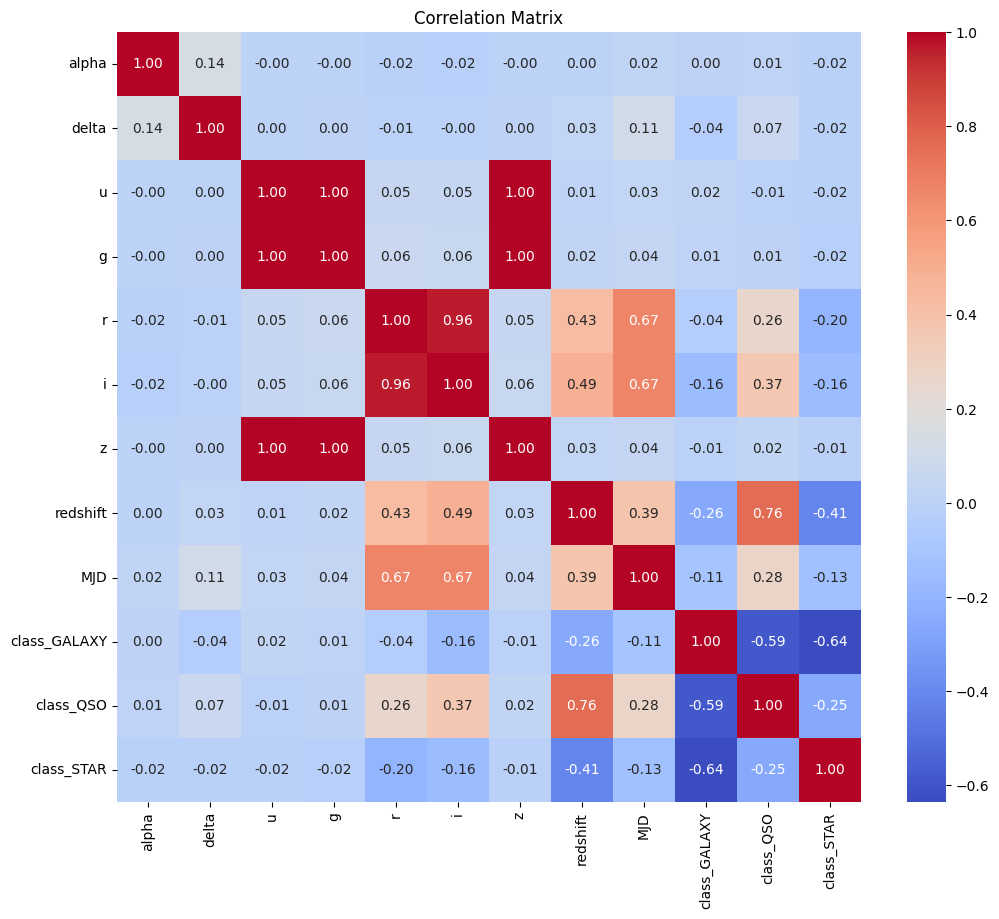

In [12]:
df_classdropped = df_transformed.drop(columns=['class'])
df_classdropped = df_classdropped.convert_dtypes()
df_classdropped = df_classdropped.astype(float) #There was an issue with the conversion to df where datatypes were of type object and the corr matrix appeared empty
corr_matrix = df_classdropped.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Previous analyses have demonstrated the predictive utility of celestial coordinates, yet their non-linear relationship with the target is not captured by the correlation matrix. As for the other attributes, there is a discernible correlation between redshift, MJD, and the class labels, as well as between the photometric filters and the classes. These observations suggest that both sets of features could be valuable for prediction, with celestial coordinates requiring non-linear modeling to harness their full potential.

We now remove the onehot columns to perform the train test split

In [13]:
classes = {
    "STAR" : 0,
    "GALAXY" : 1,
    "QSO" : 2
}

In [14]:
y = df_dropped['class'].replace(classes)
X = df_dropped.drop(['class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Let's try some models

In [15]:
model_pipeline = IMBPipeline([
    ('trans', StandardScaler()),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', XGBClassifier(n_jobs=-1))
])

In [16]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans', StandardScaler()), ('sampler', SMOTE()),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=No...=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [17]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'accuracy')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier' : [XGBClassifier()],
        'classifier__n_estimators' : [100,300],
        'classifier__learning_rate' : [0.05,0.01,0.1,1],
        'classifier__max_depth' : [2,3,4,5]
    },
    {
        'classifier' : [SVC()],
        'classifier__kernel' : ['poly','rbf'],
        'classifier__gamma' : [0.01,0.1,1,6],
        'classifier__C' : [0.01,0.1,1,10]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100]
    }
]

In [18]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,classifier_configs)]

In [31]:
all_configs[-2:]

[{'sampler': [RandomOverSampler()],
  'sampler__sampling_strategy': ['minority', 1.2, 0.9, 0.7],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [3, 5, 7, 9]},
 {'sampler': [RandomOverSampler()],
  'sampler__sampling_strategy': ['minority', 1.2, 0.9, 0.7],
  'classifier': [RandomForestClassifier()],
  'classifier__n_estimators': [10, 50, 100]}]

In [38]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*3,
    scoring='f1_weighted',
    cv=2,
    verbose=3,
    n_jobs=-1
)

In [39]:
cross_validate(rs, X_train, y_train, scoring='f1_weighted', cv = 5, return_estimator=True, verbose=3)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


KeyboardInterrupt: 

### Which Features matter the most?

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, X_train, y_train,
                           n_repeats=3,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

redshift0.527 +/- 0.002
g       0.050 +/- 0.000
u       0.029 +/- 0.000
z       0.025 +/- 0.000
i       0.020 +/- 0.000
MJD     0.015 +/- 0.000
r       0.011 +/- 0.000
alpha   0.005 +/- 0.000
delta   0.005 +/- 0.000
